In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

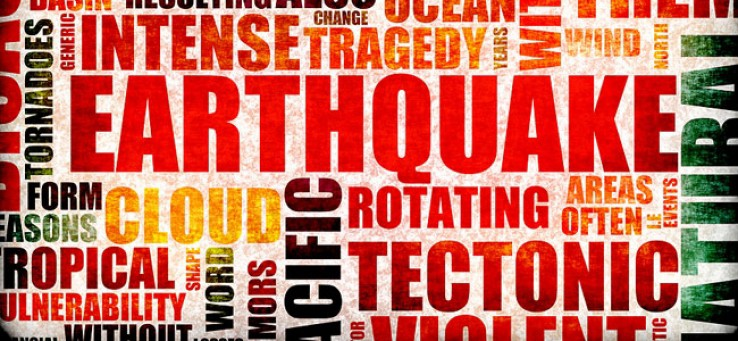

In [ ]:
#Reading File
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
#importing the required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict


In [ ]:
#importing the required tensorflow libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential

In [ ]:
#Lets take a glimpse of dataset
df_train.head()

In [ ]:
print(df_train.shape)
print(df_test.shape)

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

In [ ]:
#Lets drop keyword and location column
df_train = df_train.drop(['keyword','location'], axis=1)
df_test = df_test.drop(['keyword','location'], axis=1)

In [ ]:
df_train['text'][:9]

***DATA VISUALIZATION***

In [ ]:
#Visualizing class distribution 
plt.figure(figsize=(12,8))
sns.countplot(y='target',data = df_train,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

In [ ]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = df_train['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=df_train,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

In [ ]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = df_train['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=df_train,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

***DATA CLEANING***

In [ ]:
#Removing URLS
def url_clean(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [ ]:
#Removing HTML tags
def html_clean(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df_train['text']= df_train['text'].apply(lambda x : url_clean(x))
df_train['text']= df_train['text'].apply(lambda x : html_clean(x))

df_test['text']= df_test['text'].apply(lambda x : url_clean(x))
df_test['text']= df_test['text'].apply(lambda x : html_clean(x))

df_test['text']= df_test['text'].apply(lambda x : remove_emoji(x))
df_test['text']= df_test['text'].apply(lambda x : remove_emoji(x))

***DATA PREPARATION***

In [ ]:
#Extracting the tweets for modelling 
train_text = [x for x in df_train.text]
test_text = [x for x in df_test.text]

In [ ]:
#Data preparation for LSTM
#voc_size = 5000
voc_size = 50000
onehot_repr =[one_hot(word,voc_size)for word in train_text]
onehot_repr_test =[one_hot(word,voc_size)for word in test_text]
sent_length =157
embedded_docs = pad_sequences(onehot_repr,padding = 'pre',maxlen = sent_length)
embedded_test_docs = pad_sequences(onehot_repr_test,padding = 'pre',maxlen = sent_length)

***DATA MODELLING***

In [ ]:
#Model Architecture
embedding_vector_features = 40
model =Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(75,return_sequences =True))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])
print(model.summary())

In [ ]:
#Creating final training data
X_final = np.array(embedded_docs)
y_final = np.array(df_train['target'])

In [ ]:
#Creating final input data
X_test_final = np.array(embedded_test_docs)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs=10,batch_size=64)

In [ ]:
predictions = (model.predict(X_test_final) > 0.5).astype("int32")

In [ ]:
df_test['target'] = predictions

In [ ]:
df_submission = df_test[['id','target']]

In [ ]:
df_submission.to_csv('submission.csv',index=False)